### Plotting Function

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# FORMATTING SETTINGS
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1.3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.width'] = 1.3
mpl.rcParams['ytick.minor.width'] = 1

### Plotting variables ###
size = 3 ## Size of markers.
esize = 1 ## Size of error bar lines.
csize = 3 ## Size (width) of error bar caps.
cesize = 1 ## Size (height) of error bar caps.
trans = 0.07 ## Transparency (1 - opacity) of markers.
etrans= trans ## Transparency (1 - opacity) of error bars.
aesize = 0.5 ## Size of average point error bar line.
acsize = 3 ## Size (width) of average point error bar caps.
acesize = 0.5 ## Size (height) of average point error bar caps.
atrans = 1 ## Transparency (1 - opacity) of average point error bars.


def plotstart(data, x_label='x', y_label='y', dataset=[""], x_err=None, y_err=None, legend_title=None, f=None, colours = ["Red", "Turquoise", "Green"]):
    
    markers = [".", "s", "^"]

    plt.figure(dpi=200)
    ax = plt.axes(projection="rectilinear")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    for x in range(len(data)):
        if x<3: #OVERDENSITY ONLY
            plt.plot(data[x][0], data[x][1], ms=3, c=colours[x], marker=".", alpha=trans, linestyle="None")
        elif x>5: #Lines of best fit
            plt.plot(data[x][0], data[x][1], c=colours[x], linewidth=1)
        else:
            plt.plot(data[x][0], data[x][1], ms=3, c=colours[x], marker=".",
                label=dataset[x], linestyle="None")

        if x_err:
            plt.errorbar(x=data[x][0], y=data[x][1],
                            xerr=x_err[x], c=colours[x], alpha=atrans, linestyle="None", elinewidth=aesize, capsize=acsize, markeredgewidth=acesize, label=dataset[x])
        if y_err:
            plt.errorbar(x=data[x][0], y=data[x][1],
                            yerr=y_err[x], c=colours[x], alpha=atrans, linestyle="None", elinewidth=aesize, capsize=acsize, markeredgewidth=acesize, label=dataset[x])
        
    if f:
        # add a single error bar for the SFR vs Redshift for different mass bins
        plt.errorbar(x=data[1][0][f], y=data[1][1][f], yerr=0.66, c="Turquoise", alpha=atrans, linestyle="None", elinewidth=aesize, capsize=acsize, markeredgewidth=acesize)
    
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    plt.tick_params(which="both", direction='out', top=False, right=False)
    
    if len(dataset) > 1:
        plt.legend()
        if legend_title:
            plt.legend(title=legend_title)
        
    plt.show()

Import required modules and filter merged GZ + Lega-C dataset

In [2]:
import pandas as pd
import numpy as np

raw = pd.read_csv("/Users/nickmisiiuk/dev/PHYS369/data/legac+gz.csv")

low_mag = raw[(raw["ip_mag"] <= 22) & (raw["zp_mag"] <= 22)] #remove high magnitude galaxies and reduce uncertainty

gal_smooth = low_mag[low_mag["type"] == "S"]

gal_feat = low_mag[low_mag["type"] == "F"]

Import full Lega-C and filter

In [ ]:
legac = pd.read_csv("/Users/nickmisiiuk/dev/PHYS369/data/legac.csv")
legac_1 = legac[(legac["ip_mag"] <= 22) & (legac["zp_mag"] <= 22)]

#Filter anomalies
legac_final = legac_1[(legac_1["lsfr_UV"]> -2) & (legac_1["lsfr_IR"]> -2) & (legac_1["sfr_3ghz"]> 10)]

legac_final["lsfr_3ghz"] = legac_final["sfr_3ghz"].apply(np.log)

### Fitting a Linear Regression Model
Combining SFR data from UV and IR, plotting relation $A*lsfr(UV)$ + $B*lsfr(IR)$ VS SFR (radio) to determine values of A and B that produce a correlation of 1

In [ ]:
#Import required sklearn modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Define what are out model variables. We have identified that the best ones are:
x = legac_final[['lsfr_UV', 'lsfr_IR']]
# We want to predict the outcome, in this case either 0 (no claim) or 1 (claim)
y = legac_final['lsfr_3ghz']

# splitting the data into a sub-set to train and the rest to test a simple model
# Using 20% of the sample drawn up randomly multiple times to train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# creating an object of LinearRegression class
LR = LinearRegression(fit_intercept=False)
# fitting the training data and providing us with a simple model and how outcome depends linearly on the 5 parameters picked up
LR.fit(x_train,y_train)

coeffs = LR.coef_
print("A", coeffs[0])
print("B", coeffs[1])

# Get the predicted values of sfr
sfr_predicted = LR.predict(x_test)

# predicting the accuracy score
score = r2_score(y_test,sfr_predicted)

print('r^2:',score)
print('mean squared error:',mean_squared_error(y_test,sfr_predicted))
print('root mean squared error:',np.sqrt(mean_squared_error(y_test,sfr_predicted)))

Plotting the difference between the ML-predicted combined SFR and the given (radio) SFR, with a histogram on the side.

In [ ]:
A = 0.10895734150002614
B = 2.45229174853243

#Create new column of combined UV + IR sfr
legac_final["lSFR_final"] = A * legac_final["lsfr_UV"] + B * legac_final["lsfr_IR"]

#Difference column
sfr_diff = legac_final["lSFR_final"] - legac_final['lsfr_3ghz']

#Define Figure for plotting
plt.figure(dpi=200, figsize=(8,4))
plt.axes(projection="rectilinear")

#Main Plot
diff_plot = plt.subplot(121)
diff_plot.scatter(legac_final["lsfr_3ghz"], sfr_diff, s=3)

diff_plot.set_ylabel("$\Delta \mathrm{SFR}$")
diff_plot.set_xlabel("SFR$_{3GHz}$")
diff_plot.xaxis.set_minor_locator(AutoMinorLocator(4))
diff_plot.yaxis.set_minor_locator(AutoMinorLocator(4))

#Historgram
hist = plt.subplot(122)
hist.hist(sfr_diff, bins=20, orientation="horizontal")

hist.set_xlabel("$N_{count}$")
hist.set_yticklabels([])
hist.xaxis.set_minor_locator(AutoMinorLocator(4))
hist.yaxis.set_minor_locator(AutoMinorLocator(4))

plt.tight_layout()
plt.show()

sfr_uncertainty = sfr_diff.std()
print("Sigma: ", sfr_diff.std())

Filter the combined GZ + Legacy dataset

In [ ]:
#Create new column of combined UV + IR sfr
low_mag["lSFR_final"] = A * low_mag["lsfr_UV"] + B * low_mag["lsfr_IR"]

#Filter anomalies
new_df = low_mag[(low_mag["lsfr_UV"]> -90) & (low_mag["lsfr_IR"]> -90)]

smooth_df = new_df[new_df["type"] == "S"]
feat_df = new_df[new_df["type"] == "F"]

### Plot of log(SFR) against Redshift for different galaxy morphologies and masses 

In [ ]:
#Split mass into bins
smooth_m1 = smooth_df[smooth_df["fast_lmass"] <= 10.5]
smooth_m2 = smooth_df[(smooth_df["fast_lmass"] >= 10.5) & (smooth_df["fast_lmass"] <= 11)]
smooth_m3 = smooth_df[smooth_df["fast_lmass"] > 11]

feat_m1 = feat_df[feat_df["fast_lmass"] <= 10.5]
feat_m2 = feat_df[(feat_df["fast_lmass"] >= 10.5) & (feat_df["fast_lmass"] <= 11)]
feat_m3 = feat_df[feat_df["fast_lmass"] > 11]

plot_data = [[smooth_m1["z_spec"], smooth_m1["lSFR_final"]], [feat_m1["z_spec"], feat_m1["lSFR_final"]]]

plotstart(plot_data, dataset=[
          "Smooth", "Featured"], y_label="$\log_{10}(\mathrm{SFR} \ [\mathrm{M}_\odot \ \mathrm{yr}^{-1}])$", x_label="Redshift, $z$", legend_title="10 $<$ $\log_{10}$(M) $\leqslant$ 10.5", f=17)

# Task 2 -- Overdensity

Filter out anomalic overdensities and SFRs and Create overdensity bins

In [41]:
legac_overdensity = legac_1[(legac_1["darvish_overdensity"] > -90) & (legac_1["z_spec"] > -90)]

# New SFR column in raw legacy dataset of combined UV + IR sfr
legac_overdensity["lSFR_final"] = A * legac_overdensity["lsfr_UV"] + B * legac_overdensity["lsfr_IR"]
legac_overdensity["lSFR_final"] = A * legac_overdensity["lsfr_UV"] + B * legac_overdensity["lsfr_IR"]

# Filter very low and high SFRs
SFR_MASK  = (legac_overdensity["lSFR_final"] > -5) & (legac_overdensity["lSFR_final"] < 10)
legac_overdensity = legac_overdensity[SFR_MASK]

# Take Log of overdensity
legac_overdensity["log_overdensity"] = np.log10(legac_overdensity["darvish_overdensity"])

#Create different overdensity bins
legac_overdensity_1 = legac_overdensity[(legac_overdensity["z_spec"] > 0.6) & (legac_overdensity["z_spec"] <= 0.75)]
legac_overdensity_2 = legac_overdensity[(legac_overdensity["z_spec"] > 0.75) & (legac_overdensity["z_spec"] <= 0.85)]
legac_overdensity_3 = legac_overdensity[(legac_overdensity["z_spec"] > 0.85) & (legac_overdensity["z_spec"] <= 1)]

/var/folders/wn/gh2cl0591kl0782h2mzq82080000gr/T/ipykernel_79985/1093408586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legac_overdensity["lSFR_final"] = A * legac_overdensity["lsfr_UV"] + B * legac_overdensity["lsfr_IR"]
/var/folders/wn/gh2cl0591kl0782h2mzq82080000gr/T/ipykernel_79985/1093408586.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legac_overdensity["lSFR_final"] = A * legac_overdensity["lsfr_UV"] + B * legac_overdensity["lsfr_IR"]


Sorting and splitting the binned redshift datasets into bins of equal overdensity

In [42]:
lsfr_binned = []
density_binned = []
# Sort by overdensity and split each of the redshift bins
for bin in [legac_overdensity_1, legac_overdensity_2, legac_overdensity_3]:
    dens_sorted = bin.sort_values(["log_overdensity"])
    dens_split = np.array_split(dens_sorted, 5)

# Calculate mean SFR and mean density for each overdensity bin
    mean_lSFRs = []
    mean_DENSITIES = []
    for arr in dens_split:
        mean_lSFRs.append(arr["lSFR_final"].mean())
        mean_DENSITIES.append(arr["log_overdensity"].mean())
    
    lsfr_binned.append(mean_lSFRs)
    density_binned.append(mean_DENSITIES)

Fit linear regression lines for each of the three different redshift bins

In [43]:
# Get the straight line coefficients
# reg_1 = np.polyfit(density_binned[0], lsfr_binned[0], 1)
# reg_2 = np.polyfit(density_binned[1], lsfr_binned[1], 1)
# reg_3 = np.polyfit(density_binned[2], lsfr_binned[2], 1)
reg_1 = np.polyfit(legac_overdensity_1["log_overdensity"], legac_overdensity_1["lSFR_final"], 1)
reg_2 = np.polyfit(legac_overdensity_2["log_overdensity"], legac_overdensity_2["lSFR_final"], 1)
reg_3 = np.polyfit(legac_overdensity_3["log_overdensity"], legac_overdensity_3["lSFR_final"], 1)

# Compose straight lines
y_1 = np.multiply(reg_1[0], np.linspace(-1, 1, 50)) + reg_1[1]
y_2 = np.multiply(reg_2[0], np.linspace(-1, 1, 50)) + reg_2[1]
y_3 = np.multiply(reg_3[0], np.linspace(-1, 1, 50)) + reg_3[1]

print("Coefficients: ", reg_1[0], reg_2[0], reg_3[0])

Coefficients:  -0.6092913112933593 -0.5694531561178803 -0.2935250468803659


Plot of log(SFR) vs Overdensity for different redshift bins. Three straight line fits are also included.

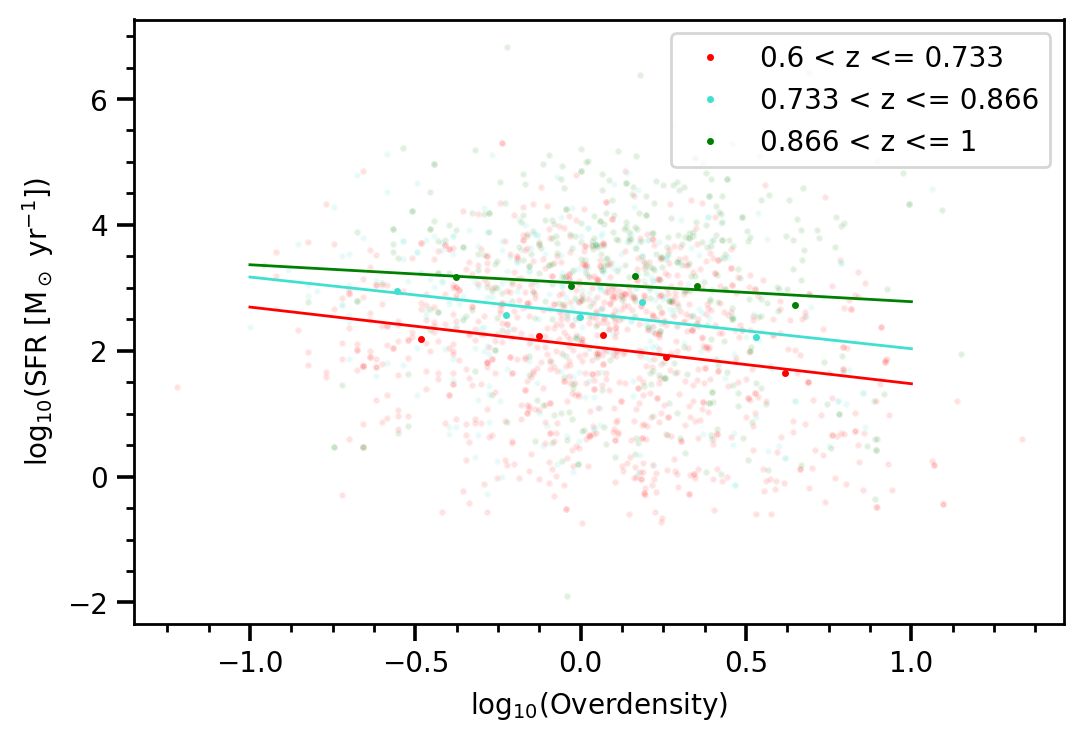

In [44]:
plot_data = [
[legac_overdensity_1["log_overdensity"], legac_overdensity_1["lSFR_final"]],
[legac_overdensity_2["log_overdensity"], legac_overdensity_2["lSFR_final"]],
[legac_overdensity_3["log_overdensity"], legac_overdensity_3["lSFR_final"]],
[density_binned[0], lsfr_binned[0]],
[density_binned[1], lsfr_binned[1]],
[density_binned[2], lsfr_binned[2]],
[np.linspace(-1, 1, 50), y_1],
[np.linspace(-1, 1, 50), y_2],
[np.linspace(-1, 1, 50), y_3]
]

plotstart(plot_data, dataset=[
          "", "", "", "0.6 < z <= 0.733", "0.733 < z <= 0.866", "0.866 < z <= 1"], y_label="$\log_{10}(\mathrm{SFR} \ [\mathrm{M}_\odot \ \mathrm{yr}^{-1}])$", x_label="$\log_{10}(\mathrm{Overdensity})$", colours = ["Red", "Turquoise", "Green", "Red", "Turquoise", "Green", "Red", "Turquoise", "Green"])